In [2]:
import os

import pandas as pd

from common.libs.data_analysis.SeriesDescriber import *
from common.libs.data_analysis.SeriesDescriberWRTTarget import *
from common.libs.DataDisplayer import *
import tensorflow as tf

### Data Initialization

In [3]:
TRAIN_FILE = os.path.join(os.getcwd(),
                          "inputs",
                          "model_ready",
                          "train",
                          "0.csv")

TEST_FILE = os.path.join(os.getcwd(),
                         "inputs",
                         "model_ready",
                         "test",
                         "0.csv")

In [4]:
train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(TEST_FILE)

In [5]:
xs = train_df.drop(columns=["date",
                            "store_nbr",
                            "city",
                            "state",
                            "cluster",
                            *[f"type_{chr(i)}" for i in range(ord('A'), ord('E') + 1)]],
                   axis=1)

uppercase_cols = [col for col in train_df.columns if col.isupper()]
ys = train_df[uppercase_cols]

print(xs.shape, ys.shape)
display_table(xs.head())
display_table(ys.head())

(1684, 39) (1684, 33)


,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD,dcoilwtico,vacation holiday,vacation additional,vacation bridge,vacation work day,vacation event
0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,93.076667,1,0,0,0,0
1,2.0,0.0,2.0,1091.0,0.0,470.652,0.0,1060.0,579.0,164.069,246.0,131.000,2652.0,31.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,13.0,67.0,0.0,369.101,194.0,0.0,0.0,247.29700,47.0,0.0,0.0,38.029000,93.140000,0,0,0,0,0
2,3.0,0.0,0.0,919.0,0.0,310.655,0.0,836.0,453.0,151.582,203.0,87.044,2121.0,12.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,15.0,66.0,0.0,272.319,153.0,0.0,0.0,187.27800,63.0,0.0,0.0,17.366001,92.970000,0,0,0,0,0
3,3.0,0.0,3.0,953.0,0.0,198.366,0.0,827.0,460.0,131.411,171.0,65.000,2056.0,15.0,7.0,0.0,0.0,0.0,0.0,0.0,7.0,24.0,102.0,0.0,454.172,88.0,0.0,0.0,258.02300,67.0,0.0,0.0,29.907001,93.120000,0,0,0,0,0
4,5.0,0.0,3.0,1160.0,0.0,301.057,0.0,811.0,464.0,118.613,177.0,70.000,2216.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0,20.0,159.0,0.0,328.940,141.0,0.0,0.0,212.33301,66.0,0.0,0.0,24.842000,93.113810,0,0,0,1,0


,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000
1,2.0,0.0,2.0,1091.0,0.0,470.652,0.0,1060.0,579.0,164.069,246.0,131.000,2652.0,31.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,13.0,67.0,0.0,369.101,194.0,0.0,0.0,247.29700,47.0,0.0,0.0,38.029000
2,3.0,0.0,0.0,919.0,0.0,310.655,0.0,836.0,453.0,151.582,203.0,87.044,2121.0,12.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,15.0,66.0,0.0,272.319,153.0,0.0,0.0,187.27800,63.0,0.0,0.0,17.366001
3,3.0,0.0,3.0,953.0,0.0,198.366,0.0,827.0,460.0,131.411,171.0,65.000,2056.0,15.0,7.0,0.0,0.0,0.0,0.0,0.0,7.0,24.0,102.0,0.0,454.172,88.0,0.0,0.0,258.02300,67.0,0.0,0.0,29.907001
4,5.0,0.0,3.0,1160.0,0.0,301.057,0.0,811.0,464.0,118.613,177.0,70.000,2216.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0,20.0,159.0,0.0,328.940,141.0,0.0,0.0,212.33301,66.0,0.0,0.0,24.842000


In [6]:
SHOW_IMAGE = False

if SHOW_IMAGE:
    import matplotlib.pyplot as plt

    # Create subplots
    n_cols = len(uppercase_cols)
    fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, n_cols * 2))
    axes = axes.flatten()

    for idx, col in enumerate(uppercase_cols):
        ys[col].plot(ax=axes[idx])
    axes[idx].set_title(col)
    axes[idx].set_xlabel('time')

    # Hide empty subplots
    for idx in range(len(uppercase_cols), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

### Model creation

In [18]:
import math

NUM_UNROLLINGS = 50
BATCH_SIZE = 200

NUM_NODES_LSTM = [30, 30]
N_LAYERS_LSTM = len(NUM_NODES_LSTM)

NUM_NODES_DENSE_BEFORE = [30]
N_LAYERS_DENSE_BEFORE = len(NUM_NODES_DENSE_BEFORE)

VALIDATION_SPLIT = 0.2

SPLIT_LOC = math.floor(xs.shape[0] * VALIDATION_SPLIT)

DROPOUT = 0.2  # Dropout amount


In [19]:
from common.classes.DataGenerators import SeqDataGeneratorXY

tf.compat.v1.reset_default_graph()

xs_np_all = xs.to_numpy()
ys_np_all = ys.to_numpy()

xs_np = xs_np_all[:SPLIT_LOC]
ys_np = ys_np_all[:SPLIT_LOC]

val_xs = xs_np_all[SPLIT_LOC:]
val_ys = ys_np_all[SPLIT_LOC:]

print(xs_np_all.shape, ys_np_all.shape)
print(xs_np.shape, ys_np.shape)
print(val_xs.shape, val_ys.shape)

# Input data
dg_train = SeqDataGeneratorXY(xs_np, ys_np, BATCH_SIZE, NUM_UNROLLINGS)
df_val = SeqDataGeneratorXY(val_xs, val_ys, BATCH_SIZE // 2, NUM_UNROLLINGS)
train_inputs, train_outputs = dg_train.unroll_batches()
val_inputs, val_outputs = df_val.unroll_batches()

print(train_inputs.shape)
print(train_outputs.shape)
print(val_inputs.shape)
print(val_outputs.shape)

(1684, 39) (1684, 33)
(336, 39) (336, 33)
(1348, 39) (1348, 33)
(200, 50, 39)
(200, 50, 33)
(100, 50, 39)
(100, 50, 33)


In [20]:
import tensorflow.keras.layers as layers

model_layers = [
    layers.Input(shape=(train_inputs.shape[1], train_inputs.shape[2])),
    *[layers.LSTM(
            NUM_NODES_LSTM[layer],
            return_sequences=True
    ) for layer in range(N_LAYERS_LSTM)],
    *[layers.TimeDistributed(
            layers.Dense(
                    NUM_NODES_DENSE_BEFORE[layer],
                    activation="relu"
            )
    ) for layer in range(N_LAYERS_DENSE_BEFORE)],
    layers.TimeDistributed(
            layers.Dense(train_outputs.shape[2])
    ),
]

model = tf.keras.Sequential(model_layers)

model.compile(
        optimizer='adam',
        loss='mse',
        metrics=[
            'mae'
        ]
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 50, 30)         │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50, 30)         │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 50, 30)         │           930 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 50, 33)         │         1,023 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,673 (69.04 KB)

 Trainable params: 17,673 (69.04 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from common.classes.CustomCallbacks import BatchMetricsCallbackVal

epochs = 1000
train_dataset = tf.data.Dataset.from_generator(
        dg_train.as_generator(),
        output_signature=(
            tf.TensorSpec(shape=train_inputs.shape, dtype=tf.float32),
            tf.TensorSpec(shape=train_outputs.shape, dtype=tf.float32)
        )
).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_generator(
        df_val.as_generator(),
        output_signature=(
            tf.TensorSpec(shape=val_inputs.shape, dtype=tf.float32),
            tf.TensorSpec(shape=val_outputs.shape, dtype=tf.float32)
        )
).prefetch(tf.data.AUTOTUNE)

# Train using model.fit with dataset
callback = BatchMetricsCallbackVal()
history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        steps_per_epoch=1,
        validation_steps=1,
        callbacks=[callback],
        verbose=2,
)


Epoch 1/1000
1/1 - 4s - 4s/step - loss: 156762.3125 - mae: 153.4908 - val_loss: 503940.1875 - val_mae: 285.9156
Epoch 2/1000
1/1 - 0s - 95ms/step - loss: 155069.1250 - mae: 152.5838 - val_loss: 479090.6250 - val_mae: 276.7602
Epoch 3/1000
1/1 - 0s - 100ms/step - loss: 155945.5000 - mae: 153.0646 - val_loss: 491244.6875 - val_mae: 281.8052
Epoch 4/1000
1/1 - 0s - 92ms/step - loss: 155590.0000 - mae: 152.8354 - val_loss: 488393.5312 - val_mae: 281.3620
Epoch 5/1000
1/1 - 0s - 90ms/step - loss: 155676.2812 - mae: 152.7975 - val_loss: 473756.2500 - val_mae: 275.9672
Epoch 6/1000
1/1 - 0s - 92ms/step - loss: 155514.9688 - mae: 152.9484 - val_loss: 481920.9062 - val_mae: 278.5390
Epoch 7/1000
1/1 - 0s - 90ms/step - loss: 155784.7031 - mae: 152.9816 - val_loss: 475773.7500 - val_mae: 276.3282
Epoch 8/1000
1/1 - 0s - 90ms/step - loss: 154671.9531 - mae: 152.3156 - val_loss: 499190.4688 - val_mae: 282.4311
Epoch 9/1000
1/1 - 0s - 96ms/step - loss: 157432.2969 - mae: 153.7288 - val_loss: 499747.

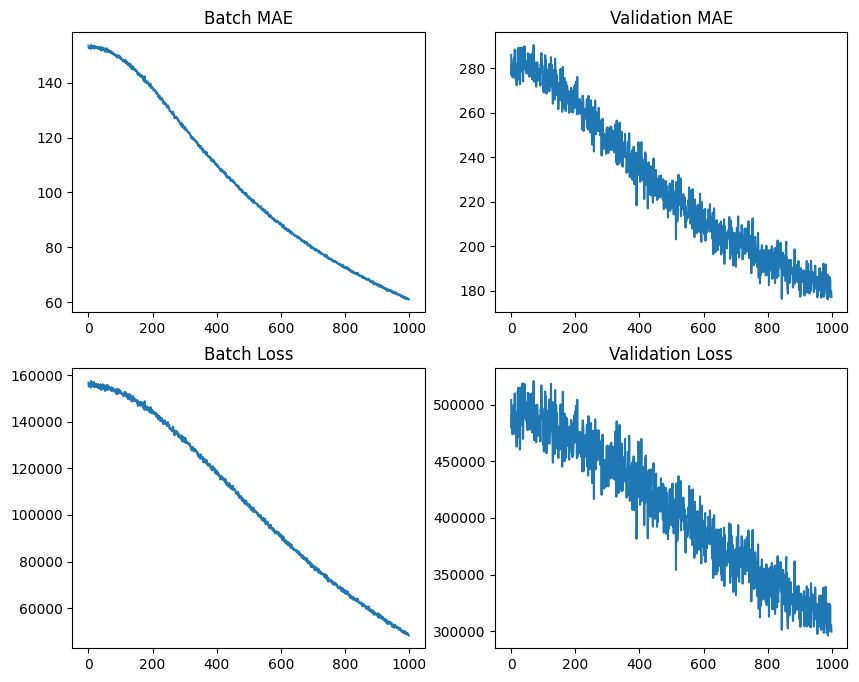

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0, 0].plot(callback.batch_maes)
ax[0, 0].title.set_text('Batch MAE')
ax[0, 1].plot(callback.val_maes)
ax[0, 1].title.set_text('Validation MAE')

ax[1, 0].plot(callback.batch_losses)
ax[1, 0].title.set_text('Batch Loss')
ax[1, 1].plot(callback.val_losses)
ax[1, 1].title.set_text('Validation Loss')

plt.show()

In [ ]:
# Ask how to create generators in tensorflow (and how they work)
# Ask if looks like overfitting